# Tarea 2: ¿Es posible explicar la cantidad de billonarios en base al desarrollo país?  <a class="tocSkip"></a>







En 2006 *Daniel Treisman* publicó un artículo titulado [*Russia Billionaries*](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068) en el cual conectó la cantidad de billonarios de un país con ciertos atributos económicos de los mismos. 

Su conclusión principal fue que ***Rusia tiene una cantidad de billonarios mayor que la que predicen los indicadores económicos***

En esta tarea ustedes analizarán datos macroeconómicos para comprobar o refutar los hallazgos de *D. Treisman*

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas de programación si no se cumple este requisito
1. Su tarea se evaluará en base al último commit antes de la fecha de entrega: **14:10 del Martes 15 de Junio de 2021**. La nota se calcula como ("pt totales" + 1)
1. [Sean leales y honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish), no copie ni comparta resultados con otros grupos

## Datos

Para esta tarea se les provee de un conjunto de datos `billonarios.csv` indexado por país con los siguientes atributos

- `nbillonarios`: La cantidad de billonarios del pais
- `logpibpc`: El logaritmo del Producto Interno Bruto (PIB) per capita del pais
- `logpob`: El logaritmo de la población del pais
- `gatt`: La cantidad de años que el pais está adherido al *General Agreement on Tariffs and Trade* (GATT)

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy.stats import poisson
import ipywidgets as widgets

df = pd.read_csv("billonarios.csv")
df.head(5)

,pais,nbillonarios,logpibpc,logpob,gatt
0,United States,469,10.786021,19.532846,60
1,Canada,25,10.743365,17.319439,0
2,"Bahamas, The",0,10.072139,12.760934,0
3,Aruba,0,10.223734,11.526276,0
4,Bermuda,0,11.446847,11.086334,0


## Modelo (1.0pt)

El objetivo principal de esta tarea es entrenar un modelo de regresión que prediga la cantidad de billonarios en función de los demás atributos

> El número de billonarios es una variable entera y no-negativa. 

Un modelo apropiado en este caso es la [regresión de Poisson](https://en.wikipedia.org/wiki/Poisson_distribution), donde definimos la probabilidad condicional para un pais $i$ como  

$$
p(y_i | x_i ) = \frac{\lambda_i^{y_i}}{y_i!} \exp \left ({-\lambda_i} \right)
$$

con intensidad

$$
\lambda_i = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)
$$

donde 

- $\theta$ es el vector de parámetros que deseamos ajustar 
- $y_i$ y $x_i$ son la cantidad de billonarios y el vector de atributos del país $i$, respectivamente

En base a este modelo se pide que ajusten $\theta$ mediante la maximización de la verosimilitud. 

$$
\begin{align}
\hat \theta &= \text{arg}\max_\theta \log \mathcal{L} (\theta) \nonumber \\ 
&= \text{arg}\max_\theta \log \prod_{i=1}^N  p(y_i | x_i) \nonumber \\
&= \text{arg}\max_\theta \sum_{i=1}^N \log p(y_i | x_i) \nonumber
\end{align}
$$

En particular:

**1. Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro $\lambda$, ¿Qué ocurre cuando $\lambda$ es pequeño? ¿Y cuando es grande?**

La distribución de Poisson es una distribución de tipo discreta que permite modelar la probabilidad de que k fenómenos ocurran en un periodo fijo de tiempo (conociendo la tasa media (λ) de ocurrencia de estos). Además se supone que los tiempos entre ocurrencias son independientes entre sí y distribuidos exponencialmente. Esto significa que por ejemplo, si se conoce la tasa media de llegada de micros a un paradero (1 cada 15 minutos) y han transcurrido 5 minutos desde la última llegada, la probabilidad con la que se debe esperar 15 minutos para que llegue una nueva micro sigue siendo la misma que si hubieran transcurrido 0 minutos, o sea, los tiempos entre llegadas son independientes entre sí.

<IPython.core.display.Javascript object>


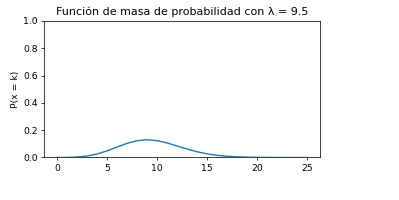

interactive(children=(FloatSlider(value=50.0, description='λ', step=0.5), Output()), _dom_classes=('widget-int…

In [14]:
k = np.arange(0,26,1)
fig, ax = plt.subplots(figsize=(8,4))
@widgets.interact(λ=(0, 100, 0.5))
def poissonMass(λ):
    y = poisson.pmf(k,λ)
    ax.cla()
    ax.set_title("Función de masa de probabilidad con λ = " + str(λ))
    ax.set_ylim([0, 1])
    ax.set_ylabel("P(x = k)")
    ax.set_xlabel("Número de ocurrencias (k)")
    ax.plot(k,y)

Podemos ver que la distribución se asemeja a una distribución normal, cuya media o centro es igual al valor de λ. También podemos observar que a medida que λ aumenta, también lo hace la varianza.
    
**2. Reemplace las expresiones y obtenga una expresión analítica para el logaritmo de la verosimilitud: $\log \mathcal{L}(\theta)$. Muestre la ecuación obtenida. HINT: Puede ignorar los términos que no dependan de $\theta$. Luego obtenga una expresión analítica para la primera derivada del logaritmo de la verosimilitud. Muestra la ecuación obtenida**
$$
\begin{align}
\log \mathcal{L}(\theta) &= \sum_{i=1}^N \log p(y_i | x_i) \nonumber \\
&= \sum_{i=1}^N \log(\frac{\lambda_i^{y_i}}{y_i!} e^{-\lambda_i}) \nonumber \\
\text{Usamos propiedad logarítmica:} \\ 
\log(a \cdot b) = \log(a) + \log(b) \\
&= \sum_{i=1}^N \log(\frac{\lambda_i^{y_i}}{y_i!} ) + \log(e^{-\lambda_i})  \nonumber \\
&= \sum_{i=1}^N \log(\frac{\lambda_i^{y_i}}{y_i!} ) - \lambda_i  \nonumber \\
\text{Usamos propiedad logarítmica:} \\ 
\log(\frac{a}{b}) = \log(a) - \log(b) \\
&= \sum_{i=1}^N \log(\lambda_i^{y_i}) - \log(y_i!) - \lambda_i  \nonumber \\
\text{Reemplazamos } \lambda_i \\
&= \sum_{i=1}^N \log((e^{(\theta_0 + \sum_{j=1}^M \theta_j x_{ij})})^{y_i}) - \log(y_i!) - e^{(\theta_0 + \sum_{j=1}^M \theta_j x_{ij})} \nonumber \\
\text{Usamos propiedad exponencial:} \\ 
(e^{a})^{b} = e^{a \cdot b} \\
&= \sum_{i=1}^N \log(e^{(\theta_0 + \sum_{j=1}^M \theta_j x_{ij}) \cdot y_i}) - \log(y_i!) - e^{(\theta_0 + \sum_{j=1}^M \theta_j x_{ij})} \nonumber \\
&= \sum_{i=1}^N (\theta_0 + \sum_{j=1}^M \theta_j x_{ij}) \cdot y_i - \log(y_i!) - e^{(\theta_0 + \sum_{j=1}^M \theta_j x_{ij})} \nonumber \\
\end{align}
$$

A mi me dio:
$$
\begin{align}
\log \mathcal{L}(\theta)&= \sum_{i=1}^N (y_i \cdot \log(\theta_0 + \sum_{j=1}^M (\theta_j \cdot x_{ij})) - \sum_{i=1}^N (e^{\theta_0} \cdot e^{\sum_{j=1}^M \theta_j \cdot x_{ij}}) \nonumber \\
\end{align}
$$

La derivada de la log verosimilitud con respecto a $\begin{align}\theta_j \end{align}$ es

$$
\begin{align}f'(\log \mathcal{L}(\theta)) = \end{align}$$

## Implementación (1.5pt)

**1. Implemente el logaritmo de la verosimilitud y su derivada usando `numpy`. Utilice operaciones vectoriales (prohibido usar `for` para iterar en los países)**


**2. Implemente una rutina que encuentre el vector de parámetros óptimo en base a `scipy.optimize.minimize`**


**3. Implemente una rutina que calcule el pseudo coeficiente de correlación
$$
R^2 = \frac{\log \mathcal{L} (\hat \theta_0) - \log \mathcal{L} (\hat \theta) }{\log \mathcal{L} (\hat \theta_0)} \in [0, 1]
$$
donde $\log \mathcal{L} (\hat \theta)$ es el logaritmo de la verosimilitud de su mejor modelo y $\log \mathcal{L} (\hat \theta_0)$ es el logaritmo de la verosimilitud de un modelo que tiene sólo el parámetro $\theta_0$**


**4. Implemente una rutina de bootstrap resampling para encontrar la distribución y los intervalos de confianza empíricos para $\theta$ y el pseudo coeficiente de correlación**

## Resultados (3pt)

1. Compare los métodos `CG`, `BFGS`, `Nelder-mead` y `Powell` en términos del vector de parámetros obtenido, la log verosimilitud alcanzada, el pseudo coeficiente de correlación alcanzado, el número de iteraciones necesarias para converger y el tiempo total para converger. Seleccione uno de los métodos para contestar los siguientes puntos
1. Muestre las distribuciones empíricas de los parámetros y del pseudo coeficiente de correlación. ¿Cuáles parámetros tienen $\theta$ significativamente distinto de cero? ¿Cuál es el intervalo de confianza al 95% del $R^2$? En base a esto ¿Qué puede decir sobre su modelo?
1. Prediga la cantidad de billonarios de cada país usando su modelo. Gráfique el error entre la cantidad de billonarios predicha y la cantidad de billonarios real. El gráfico debe mostrar los paises ordenados de mayor a menor **error absoluto**.  Analice ¿Cuáles son los 5 países con mayor error en la predicción? ¿Cuáles países tienen un exceso de billonarios? ¿Cúales paises tienen menos billonarios de lo esperado? ¿Qué puede decir sobre Rusia?



## Conclusiones (0.5pt)

Resuma sus principales hallazgos y comenté sobre las desafios encontrados al desarrollar esta tarea 